## Load records

In [1]:
import pandas as pd
data = pd.read_csv('../Stakeholders/Stakeholders-clean.csv')

## Preprocess

In [6]:
%run preprocessing.ipynb

[nltk_data] Downloading package stopwords to /Users/ajda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ajda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
ignore_words = [
    "finding", "research", "purpose", "study", "methodology", "result", 
    "analysis", "method", "paper", "literature", "tourism", "also", "within", 
    "whereas", "would", "fig", "may", "however", "could", "might"
]

In [8]:
keyword = "tourist"

In [9]:
original_tokens, verb_tokens, data_preprocessed = preprocess(data,
                                                             to_ignore=ignore_words,
                                                             keyword=keyword,
                                                             save_to_file=f'stakeholders_preprocessed_{keyword}.csv')
print('Documents kept after preprocessing: {}'.format(len(verb_tokens)))

Documents kept after preprocessing: 334


## Basic statistics

### Frequent bigrams

In [ ]:
bigram_measures = BigramAssocMeasures()
flat_tokens = [t for doc in original_tokens for t in doc]
finder = BigramCollocationFinder.from_words(flat_tokens)
finder.apply_freq_filter(5)
for (i, j), score in finder.score_ngrams(bigram_measures.pmi):
    if score > 5:
        print(i, j, ': ', score)

### Word Frequencies

Find most frequent words in the corpus.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fdist = word_frequencies(verb_tokens)

Change `show_top_n` to adjust the number of words to display.

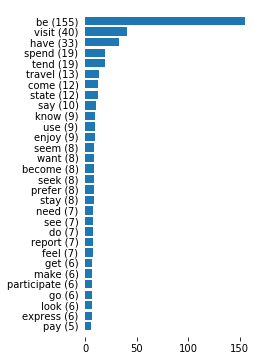

In [11]:
show_top_n = 30

# calc
mc = fdist.most_common(show_top_n)

# plot
mc = mc[::-1] ; ws, fs = zip(*mc) ; ws = ['{} ({})'.format(w, f) for w, f in mc]
plt.figure(figsize=(3, 6*show_top_n/30))
plt.box(False); plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)
plt.barh(range(len(ws)), fs) ; plt.yticks(range(len(ws)), ws); plt.ylim(-1, len(ws));
plt.savefig(f'freq-dist-stakeholders-{keyword}')

In [ ]:
mc

In [12]:
for word, freq in mc:
    doc_freq = sum(word in doc for doc in verb_tokens)
    print("{} appears {} times over {} documents".format(word, freq, doc_freq))
    print("    Average document frequency:", round(freq/doc_freq, 3))

pay appears 5 times over 4 documents
    Average document frequency: 1.25
express appears 6 times over 6 documents
    Average document frequency: 1.0
look appears 6 times over 6 documents
    Average document frequency: 1.0
go appears 6 times over 6 documents
    Average document frequency: 1.0
participate appears 6 times over 6 documents
    Average document frequency: 1.0
make appears 6 times over 6 documents
    Average document frequency: 1.0
get appears 6 times over 6 documents
    Average document frequency: 1.0
feel appears 7 times over 7 documents
    Average document frequency: 1.0
report appears 7 times over 7 documents
    Average document frequency: 1.0
do appears 7 times over 6 documents
    Average document frequency: 1.167
see appears 7 times over 6 documents
    Average document frequency: 1.167
need appears 7 times over 5 documents
    Average document frequency: 1.4
stay appears 8 times over 8 documents
    Average document frequency: 1.0
prefer appears 8 times over 

### Context of words

Find common contexts (co-occurring words) where the words from the list appear.

In [ ]:
word_list = ['travel', 'tourist']

context = word_contexts(original_tokens, word_list, num=30)

### Concordances

Find words in text and see in which contexts they appear.

In [13]:
word = "tourist"

concordance(data_preprocessed, word)

The paucity of research related to domestic medical tourism may be attributed to the widely accepted notion that medical tourists are primarily travelling across international borders .
Nonetheless, some media reports have emerged to show that more than 10,000 inbound medical tourists visited Australia in 2013 .
For instance, Yu and Ko  found that medical tourists were mostly women, with an almost equal age distribution across age groups, with tertiary qualifications and above average incomes.
Some studies have alluded to significant cost savings when medical tourists travel to less developing countries for medical tourism .
This was a point raised by concerned residents, as to whether medical tourists will have a displacement effect on their access to the medical facilities, as Vicky indicated: “
The medical tourists would bring extra funding to the area but it should not be at the expense in either cash or facilities for locals.
---- End of document ----

They believed that the regio

In [ ]:
from nltk.util import ngrams
from collections import Counter

In [ ]:
bigram_measures = BigramAssocMeasures()
flat_tokens = [t for doc in original_tokens for t in doc]
finder = BigramCollocationFinder.from_words(flat_tokens)
finder.apply_freq_filter(5)
for (i, j), score in finder.score_ngrams(bigram_measures.pmi):
    if score > 5:
        print(i, j, ': ', score)

## Sentiment of verb neighborhood

In [14]:
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [15]:
def verb_sentiment(verb):
    scores = {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
    sid = SentimentIntensityAnalyzer()
    no_sents = 0
    for row in data_preprocessed['Selected']:
        verb_in_row = False
        for sent in sent_tokenize(row.lower()):
            tokens = lemmatize(tokenize(sent))
            if verb in tokens:
                no_sents += 1
                for key, value in sid.polarity_scores(sent).items():
                    scores[key] += value
    return {k: v/no_sents for k, v in scores.items()}

In [16]:
for verb in mc:
    neg, neu, pos, com = verb_sentiment(verb[0]).values()
    # normalize by number of occurence of the verb
    neg, neu, pos, com = neg, neu, pos, com
    print(f'Score for {verb[0]}:\n    negative {neg}\n    positive {pos}\n    compound {com}')

Score for pay:
    negative 0.07365
    positive 0.1076
    compound 0.16931499999999997
Score for express:
    negative 0.05361538461538462
    positive 0.08476923076923078
    compound 0.14005384615384614
Score for look:
    negative 0.035777777777777776
    positive 0.08733333333333332
    compound 0.15357777777777779
Score for go:
    negative 0.022583333333333334
    positive 0.12083333333333335
    compound 0.3403958333333333
Score for participate:
    negative 0.015222222222222224
    positive 0.10394444444444445
    compound 0.35142777777777773
Score for make:
    negative 0.010285714285714287
    positive 0.08957142857142857
    compound 0.33602857142857145
Score for get:
    negative 0.011142857142857144
    positive 0.1227142857142857
    compound 0.3197785714285714
Score for feel:
    negative 0.022
    positive 0.07211764705882355
    compound 0.18474117647058824
Score for report:
    negative 0.036000000000000004
    positive 0.0805
    compound 0.1965625
Score for do:
  